#  [German Traffic Sign Recognition Benchmark](https://bit.ly/332gMFP)

### Celem jest zastosowanie sieci konwolucyjnych do bardziej zaawansowanego zadania (niż MNIST).

Już wiesz wystarczająco dużo, żeby zacząć realizować bardziej złożone zadanie - na przykład rozpoznawanie znaków drogowych. Na szczęście już mamy dane, pozostaje jedynie je rozpoznać. 

Dane są dość realistyczne. To oznacza, że czasem są duże trudności ze światłem lub jest mgła i inne czynniki zewnętrzne, kiedy znaku prawie nie widać. Normalne jest to, że na rzeczywistym zbiorze danych pojawiają się takie trudności.


### Przykład znaków
Poniżej jeszcze zajrzymy dokładniej do zbioru danych.

![](../images/gts.jpeg)

In [1]:
import pickle

import numpy as np
np.random.seed(0)
import pandas as pd

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

from skimage import color, exposure

from tqdm import tqdm

import matplotlib.pyplot as plt
#from matplotlib.figure import Figure

from collections import Counter

from livelossplot import PlotLossesKeras # <= automatyczne tworzenie krzywej uczenia się
%matplotlib inline

2022-11-04 21:10:46.514552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Wczytujemy dane

In [2]:
training_file = "../input/train.p"
test_file     =  "../input/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, X_test.shape)

(34799, 32, 32, 3) (4410, 32, 32, 3)


W zbiorze treningowym mamy **34 799** zdjęć, w zbiorze testowym jest ich **4 410**. Zdjęcia mają rozmiar **32x32** i są kolorowe (dlatego są trzy kanały).

In [3]:
X_train.nbytes / 1024**2

101.9501953125

**X_train** to ponad 100MB.

## Wczytujemy opisy danych

In [4]:
signnames = pd.read_csv('../input/signnames.csv')
signnames.head()

,a,b
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


## Target variable
Wszystkie możliwe znaki.

In [5]:
traffic_labels_dict = signnames[ ['b'] ].to_dict()['b']
traffic_labels_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

## Popatrzmy na znaki

===== Speed limit (20km/h) =====


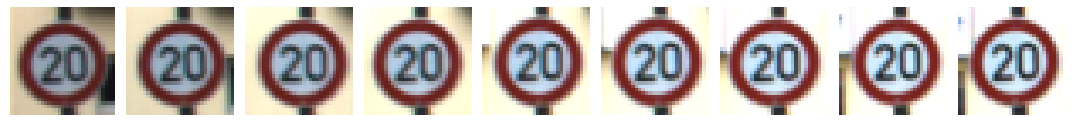

===== Speed limit (30km/h) =====


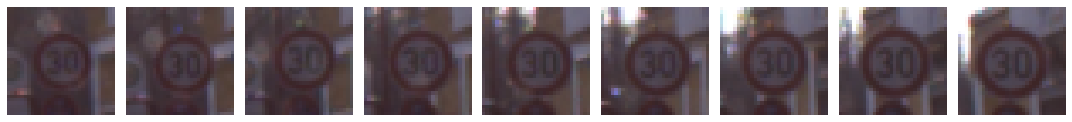

===== Speed limit (50km/h) =====


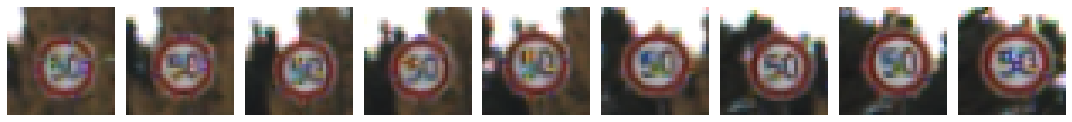

===== Speed limit (60km/h) =====


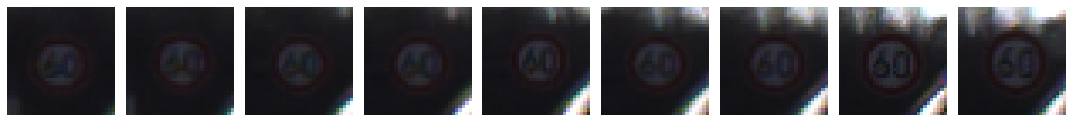

===== Speed limit (70km/h) =====


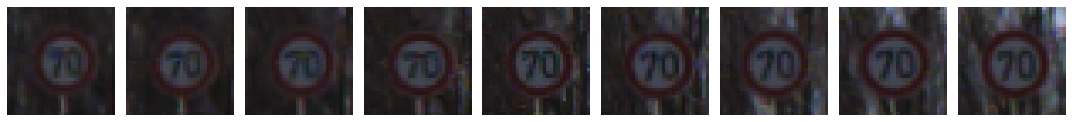

===== Speed limit (80km/h) =====


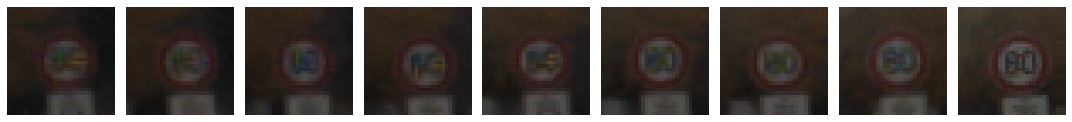

===== End of speed limit (80km/h) =====


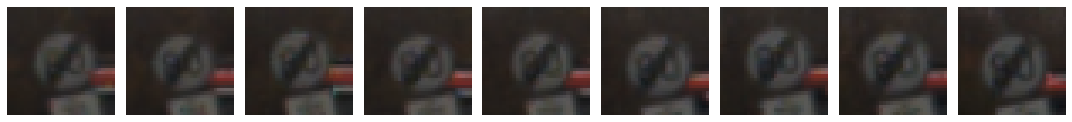

===== Speed limit (100km/h) =====


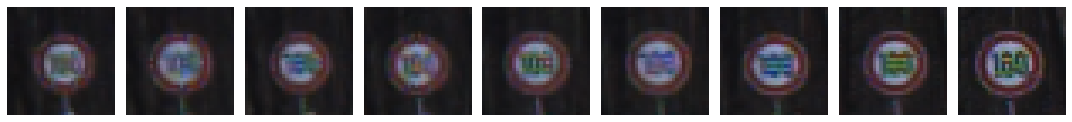

===== Speed limit (120km/h) =====


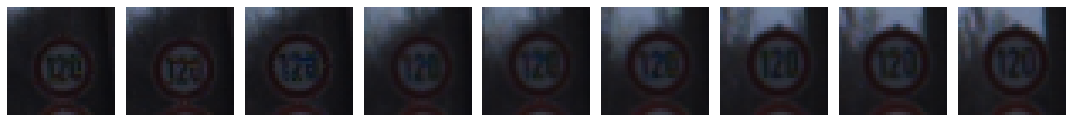

===== No passing =====


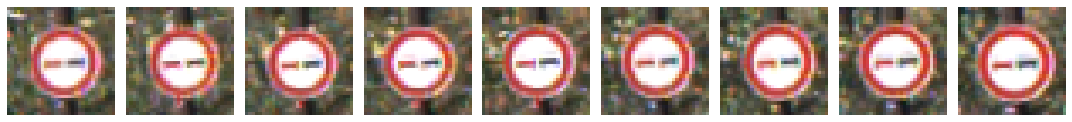

===== No passing for vehicles over 3.5 metric tons =====


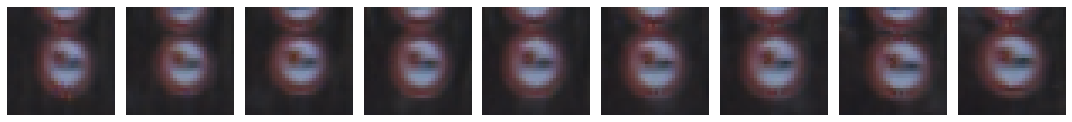

===== Right-of-way at the next intersection =====


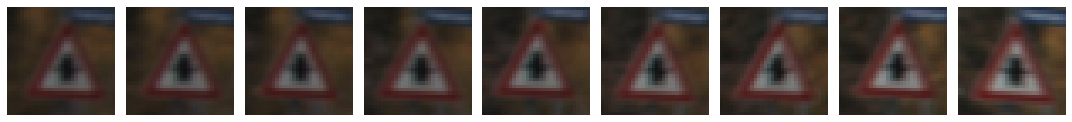

===== Priority road =====


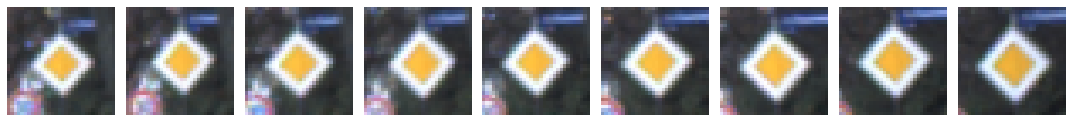

===== Yield =====


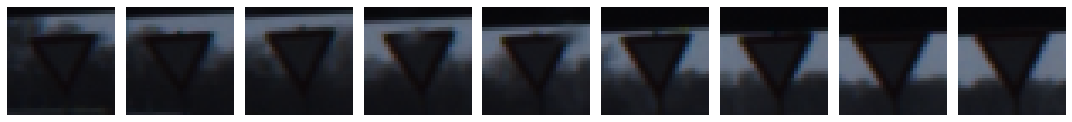

===== Stop =====


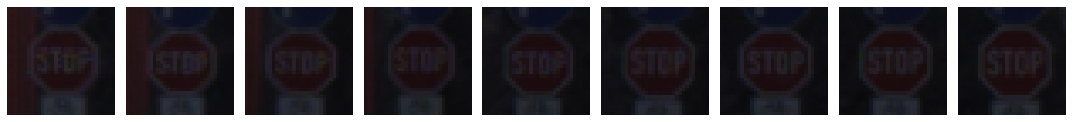

===== No vehicles =====


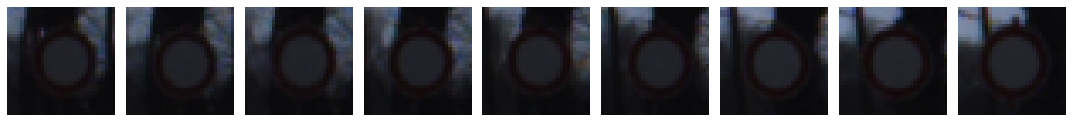

===== Vehicles over 3.5 metric tons prohibited =====


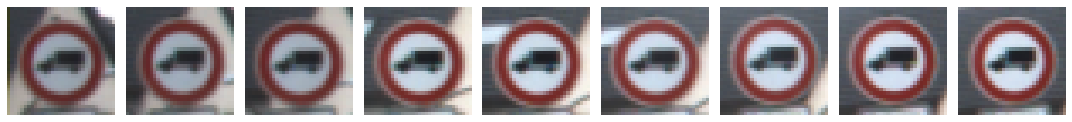

===== No entry =====


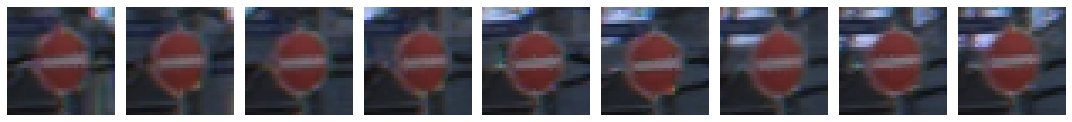

===== General caution =====


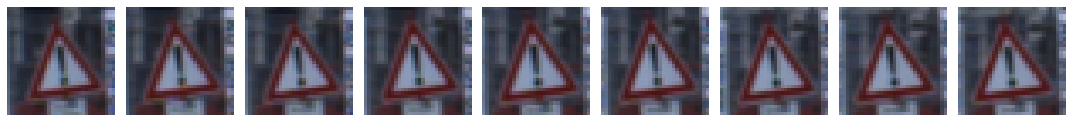

===== Dangerous curve to the left =====


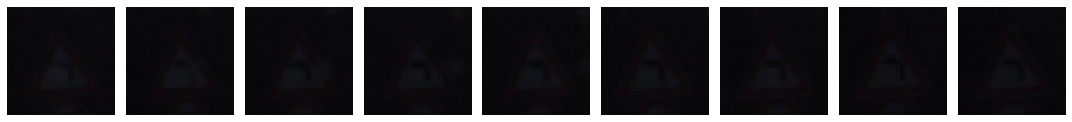

===== Dangerous curve to the right =====


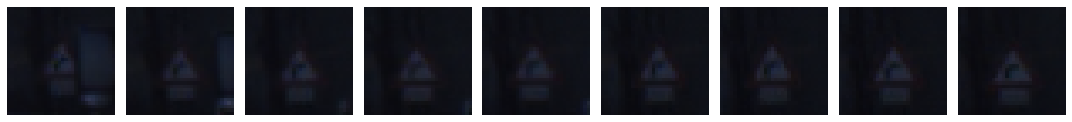

===== Double curve =====


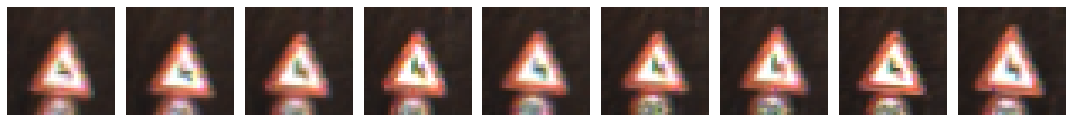

===== Bumpy road =====


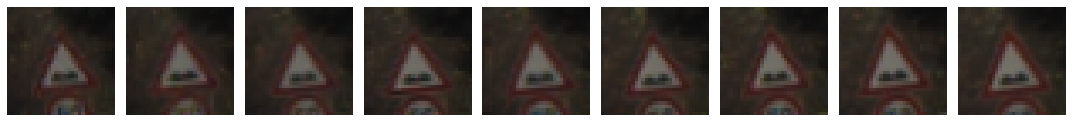

===== Slippery road =====


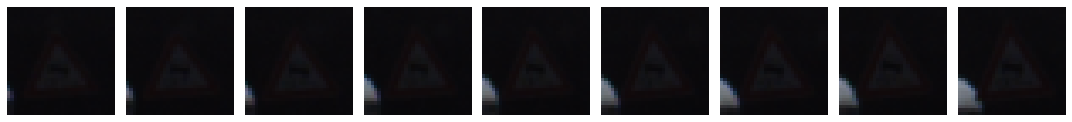

===== Road narrows on the right =====


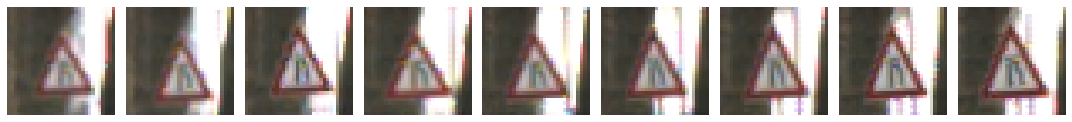

===== Road work =====


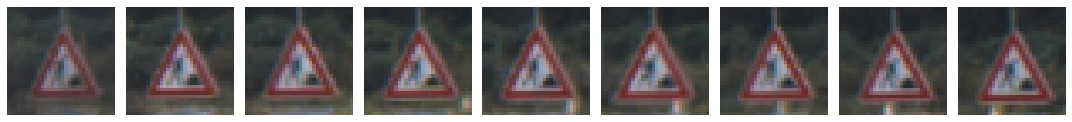

===== Traffic signals =====


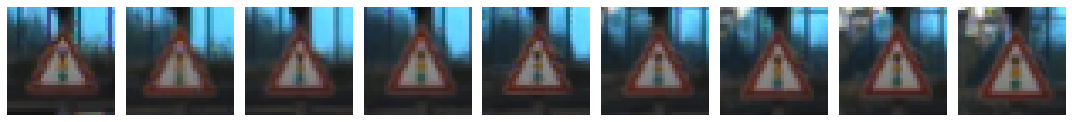

===== Pedestrians =====


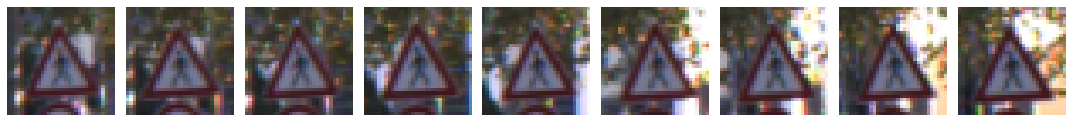

===== Children crossing =====


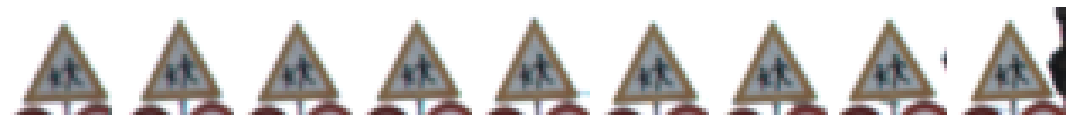

===== Bicycles crossing =====


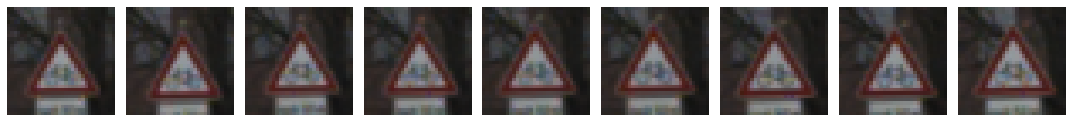

===== Beware of ice/snow =====


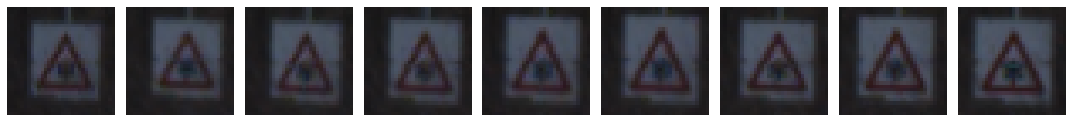

===== Wild animals crossing =====


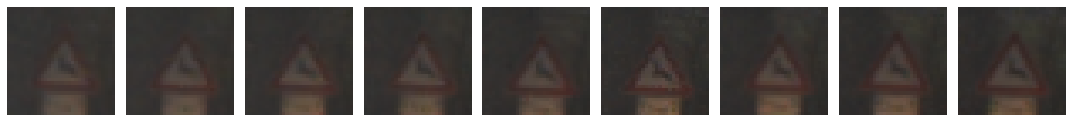

===== End of all speed and passing limits =====


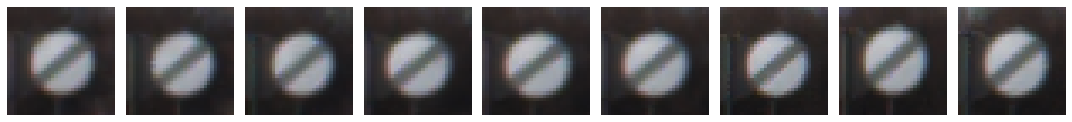

===== Turn right ahead =====


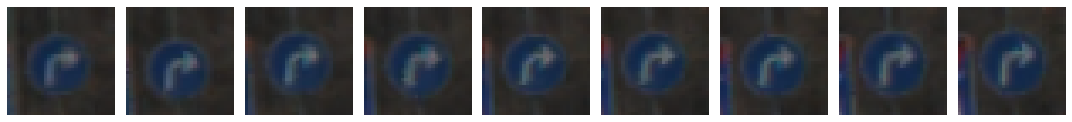

===== Turn left ahead =====


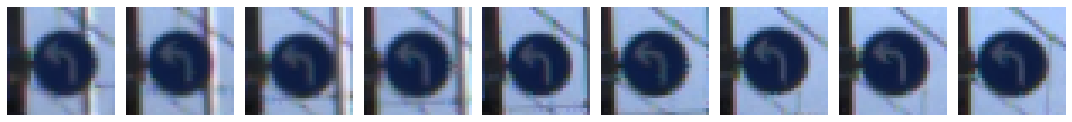

===== Ahead only =====


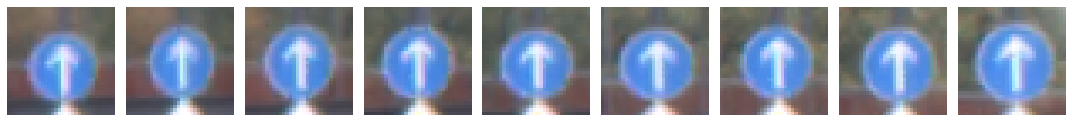

===== Go straight or right =====


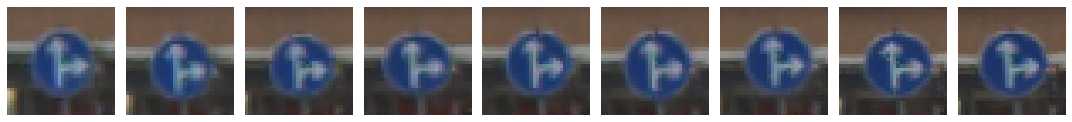

===== Go straight or left =====


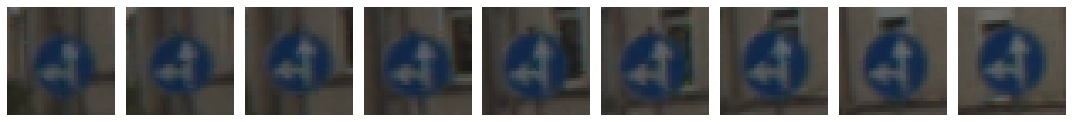

===== Keep right =====


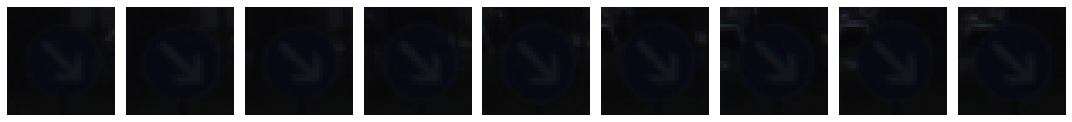

===== Keep left =====


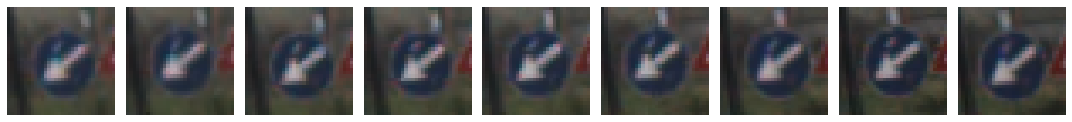

===== Roundabout mandatory =====


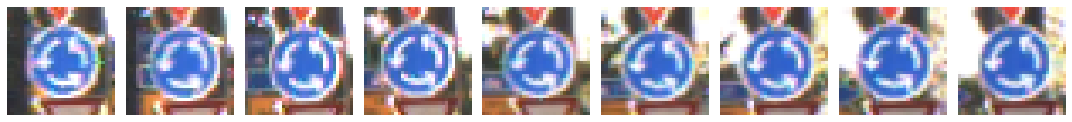

===== End of no passing =====


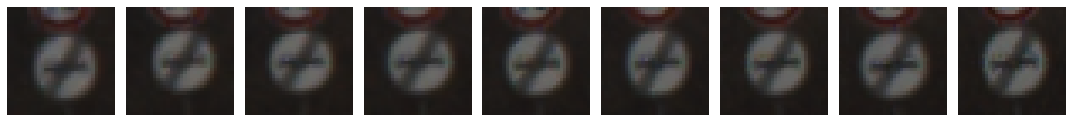

===== End of no passing by vehicles over 3.5 metric tons =====


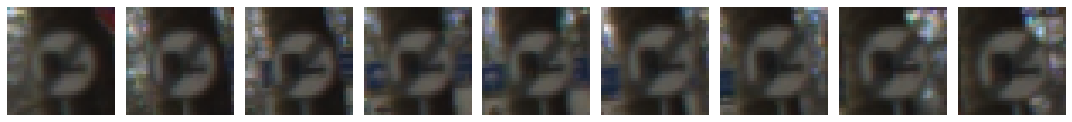

In [7]:
for sign_id in traffic_labels_dict.keys():
    print("===== {0} =====".format(traffic_labels_dict[sign_id]))
    signs = X_train[ y_train == sign_id ]
    
    plt.figure(figsize=(15, 12))
    for idx in range(9):
        plt.subplot(190 + 1 + idx)
        plt.imshow( signs[idx,])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Rozkład
Weryfikacja - jak wygląda rozkład dla poszczególnych klas.

In [8]:
[x for x in traffic_labels_dict.items()]

[(0, 'Speed limit (20km/h)'),
 (1, 'Speed limit (30km/h)'),
 (2, 'Speed limit (50km/h)'),
 (3, 'Speed limit (60km/h)'),
 (4, 'Speed limit (70km/h)'),
 (5, 'Speed limit (80km/h)'),
 (6, 'End of speed limit (80km/h)'),
 (7, 'Speed limit (100km/h)'),
 (8, 'Speed limit (120km/h)'),
 (9, 'No passing'),
 (10, 'No passing for vehicles over 3.5 metric tons'),
 (11, 'Right-of-way at the next intersection'),
 (12, 'Priority road'),
 (13, 'Yield'),
 (14, 'Stop'),
 (15, 'No vehicles'),
 (16, 'Vehicles over 3.5 metric tons prohibited'),
 (17, 'No entry'),
 (18, 'General caution'),
 (19, 'Dangerous curve to the left'),
 (20, 'Dangerous curve to the right'),
 (21, 'Double curve'),
 (22, 'Bumpy road'),
 (23, 'Slippery road'),
 (24, 'Road narrows on the right'),
 (25, 'Road work'),
 (26, 'Traffic signals'),
 (27, 'Pedestrians'),
 (28, 'Children crossing'),
 (29, 'Bicycles crossing'),
 (30, 'Beware of ice/snow'),
 (31, 'Wild animals crossing'),
 (32, 'End of all speed and passing limits'),
 (33, 'Turn r

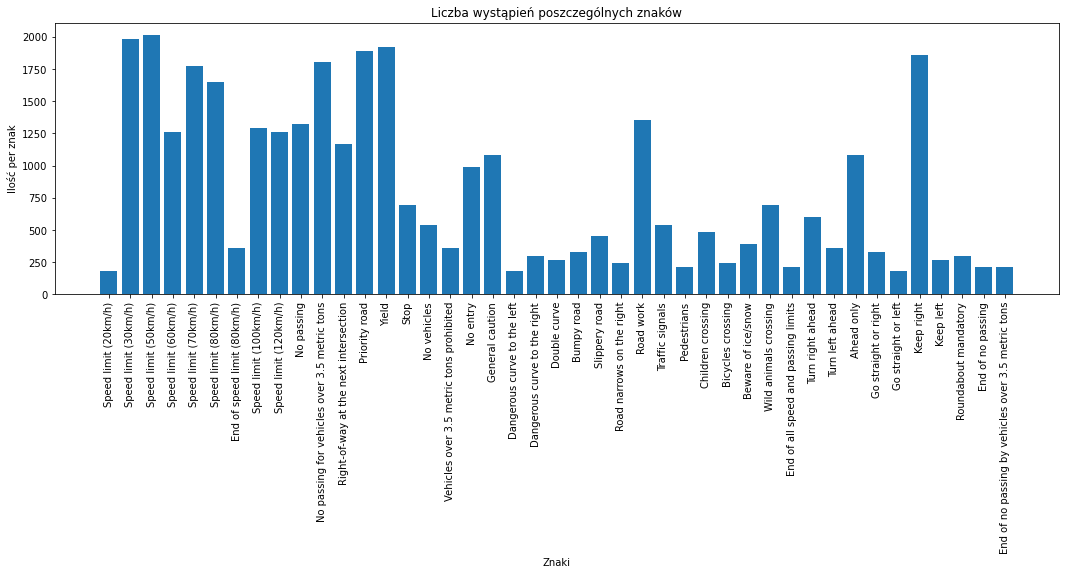

In [9]:
cnt = Counter(y_train)

plt.figure(figsize=(18, 5))
plt.title('Liczba wystąpień poszczególnych znaków')
plt.bar(list(cnt.keys()),list(cnt.values()))
plt.xlabel('Znaki')
plt.xticks(range(len(traffic_labels_dict)), [x[1] for x in traffic_labels_dict.items()], rotation=90)
plt.ylabel('Ilość per znak')
plt.show()

## Przygotowanie danych
X już są poukładane tak jak trzeba, pozostało tylko ułożyć y.

In [10]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)    
    
input_shape = X_train.shape[1:]
num_classes = len(traffic_labels_dict)

## Prosta architektura

In [11]:
def get_simple_cnn():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

get_simple_cnn().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 512)               1843712   
                                                                 
 dense_1 (Dense)             (None, 43)                22059     
                                                                 
Total params: 1,866,219
Trainable params: 1,866,219
Non-trainable params: 0
______________________________________________

2022-11-04 21:13:44.751074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model = get_simple_cnn()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Trenujemy 1

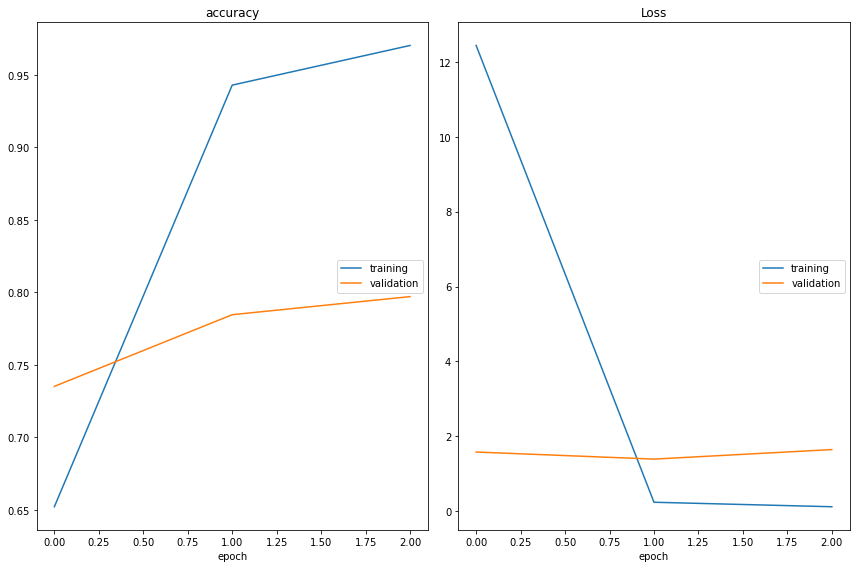

accuracy
	training         	 (min:    0.652, max:    0.970, cur:    0.970)
	validation       	 (min:    0.735, max:    0.797, cur:    0.797)
Loss
	training         	 (min:    0.119, max:   12.439, cur:    0.119)
	validation       	 (min:    1.391, max:    1.646, cur:    1.646)
272/272 [==============================] - 7s 26ms/step - loss: 0.1191 - accuracy: 0.9703 - val_loss: 1.6457 - val_accuracy: 0.7971


In [13]:
plot_losses = PlotLossesKeras()


history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

## Sprawdzamy 1

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 1.6456571817398071
Test accuracy: 0.7970521450042725
CNN Error: 20.29%


In [15]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

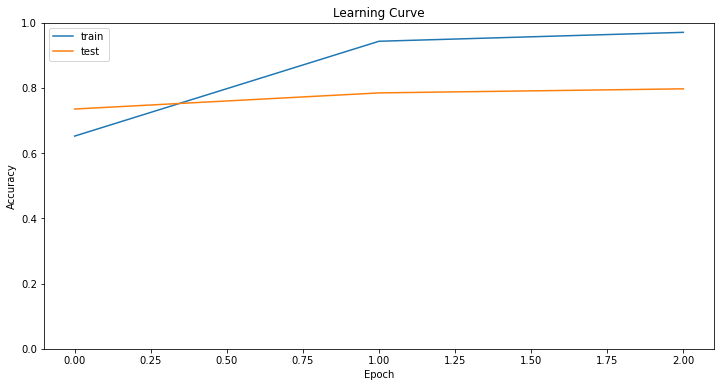

In [16]:
draw_learning_curve(history, key='accuracy', ylim=(0.0, 1.))

In [17]:
def get_cnn2_nodroput():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
    
        Flatten(), #<= bridge between conv layers and full connected layers
        
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


model = get_cnn2_nodroput()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              3212288   
                                                                 
 dense_5 (Dense)             (None, 43)                44075     
                                                      

## Trenujemy 2

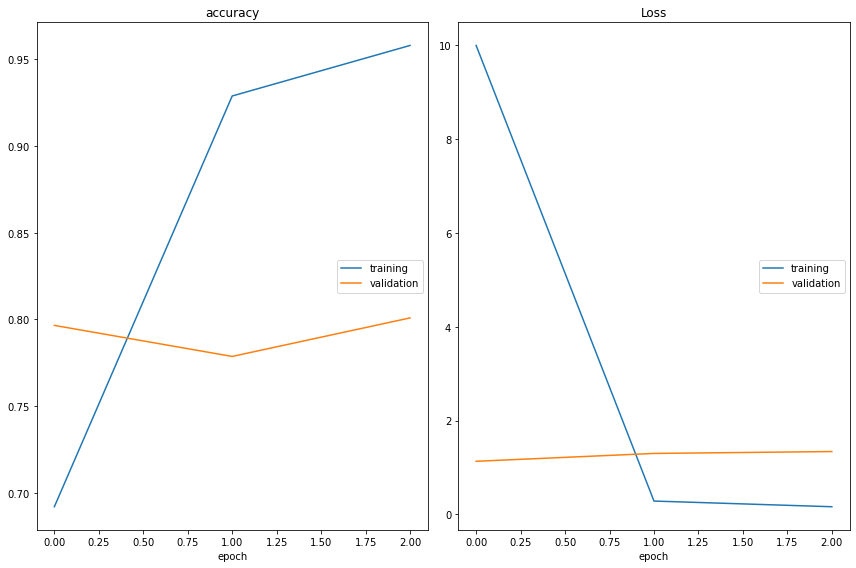

accuracy
	training         	 (min:    0.692, max:    0.958, cur:    0.958)
	validation       	 (min:    0.779, max:    0.801, cur:    0.801)
Loss
	training         	 (min:    0.164, max:    9.995, cur:    0.164)
	validation       	 (min:    1.133, max:    1.340, cur:    1.340)
272/272 [==============================] - 16s 58ms/step - loss: 0.1639 - accuracy: 0.9580 - val_loss: 1.3400 - val_accuracy: 0.8009


In [19]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

## Testujemy 2

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 1.3400152921676636
Test accuracy: 0.8009070158004761
CNN Error: 19.91%


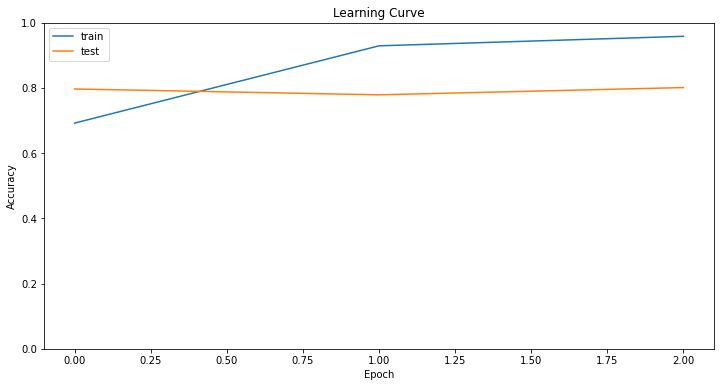

In [21]:
draw_learning_curve(history, key='accuracy', ylim=(0.0, 1.))

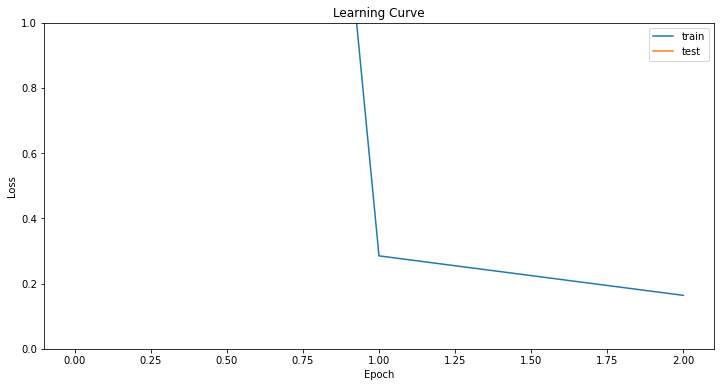

In [22]:
draw_learning_curve(history, key='loss', ylim=(0., 1.))

In [23]:
def get_doubled_cnn3_nodropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


model = get_doubled_cnn3_nodropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

## Trenujemy 4

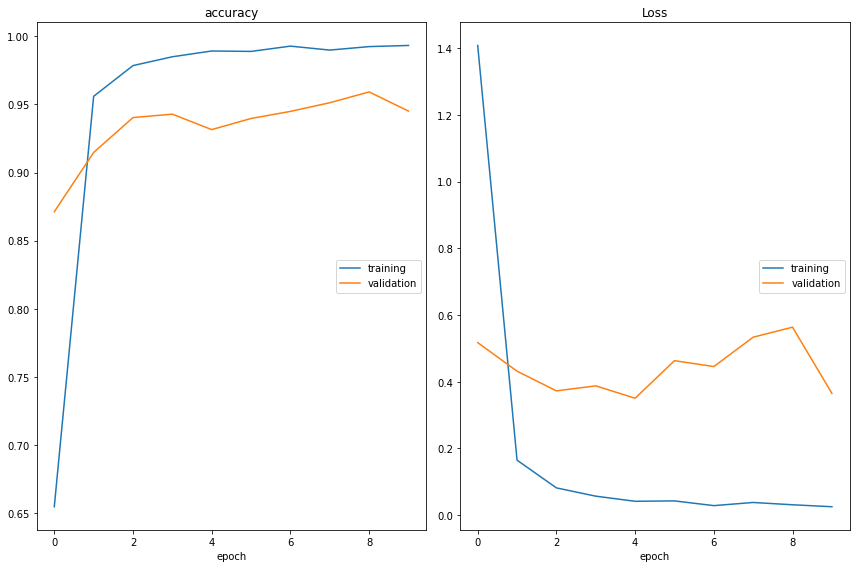

accuracy
	training         	 (min:    0.655, max:    0.993, cur:    0.993)
	validation       	 (min:    0.871, max:    0.959, cur:    0.945)
Loss
	training         	 (min:    0.025, max:    1.408, cur:    0.025)
	validation       	 (min:    0.350, max:    0.564, cur:    0.365)
272/272 [==============================] - 46s 170ms/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 0.3650 - val_accuracy: 0.9451


In [25]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))


## Testujemy 4

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.36500728130340576
Test accuracy: 0.9451247453689575
CNN Error: 5.49%


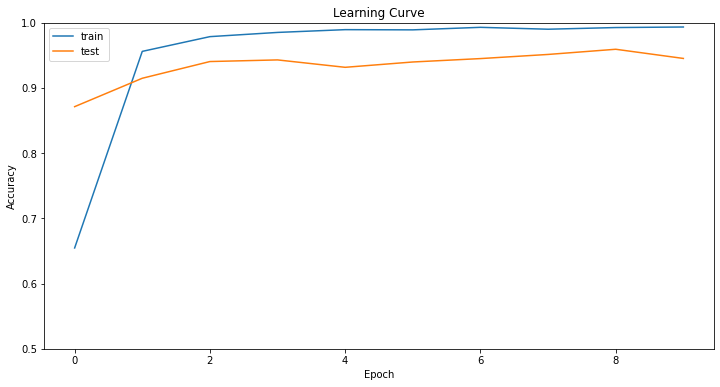

In [27]:
draw_learning_curve(history, key='accuracy', ylim=(0.5, 1.))

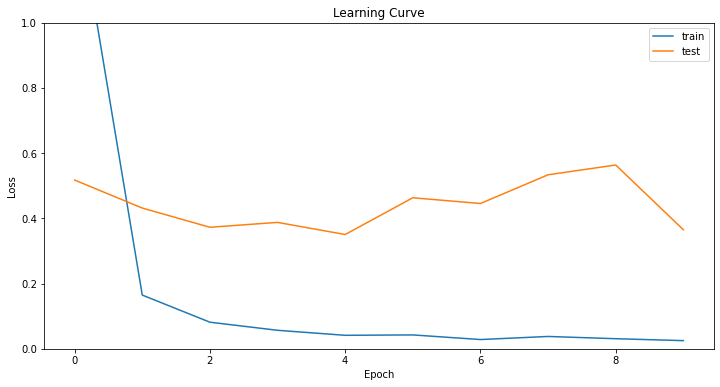

In [28]:
draw_learning_curve(history, key='loss', ylim=(0., 1.))

## Zadanie 6.5.3
Twoim zadaniem jest podziałać z przeuczeniem się. Spróbuj dodać `Dropout()` po każdym bloku i zobacz, jak to wpłynie na przeuczenie się.

In [30]:
def get_doubled_cnn3_with_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])


model = get_doubled_cnn3_with_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        36928     
                                                      

## Trenujemy 5

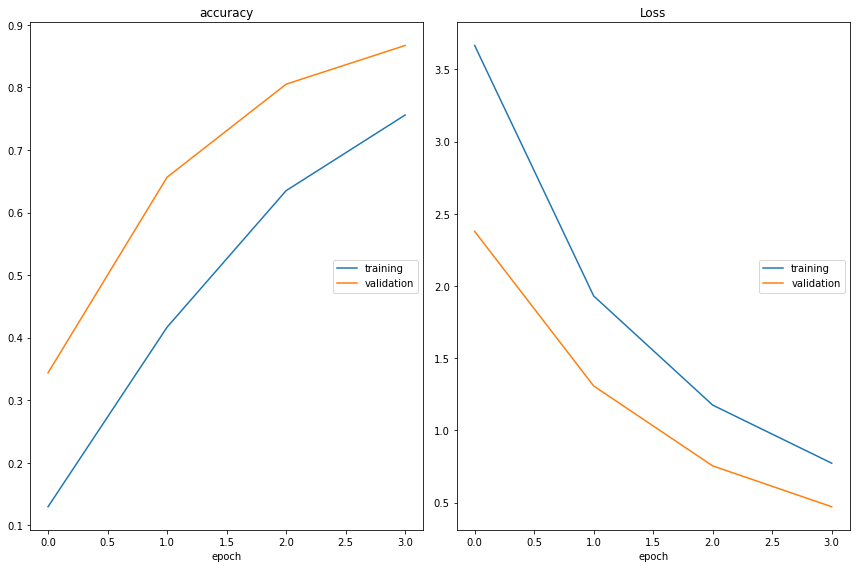

accuracy
	training         	 (min:    0.130, max:    0.756, cur:    0.756)
	validation       	 (min:    0.344, max:    0.867, cur:    0.867)
Loss
	training         	 (min:    0.773, max:    3.666, cur:    0.773)
	validation       	 (min:    0.471, max:    2.378, cur:    0.471)
272/272 [==============================] - 43s 158ms/step - loss: 0.7727 - accuracy: 0.7559 - val_loss: 0.4712 - val_accuracy: 0.8671


In [32]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

## Testujemy 5

In [33]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.47120049595832825
Test accuracy: 0.8671202063560486
CNN Error: 13.29%


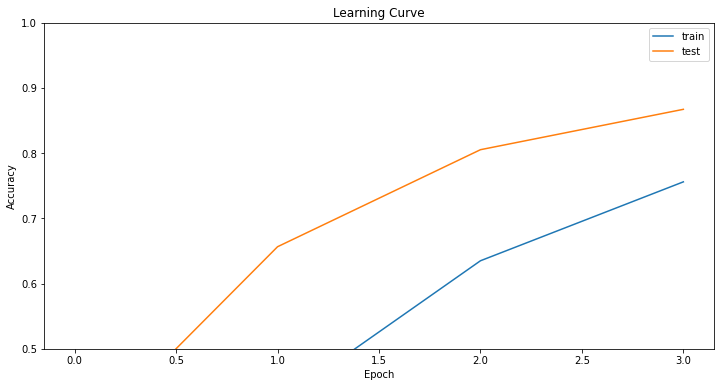

In [34]:
draw_learning_curve(history, key='accuracy', ylim=(0.5, 1.))

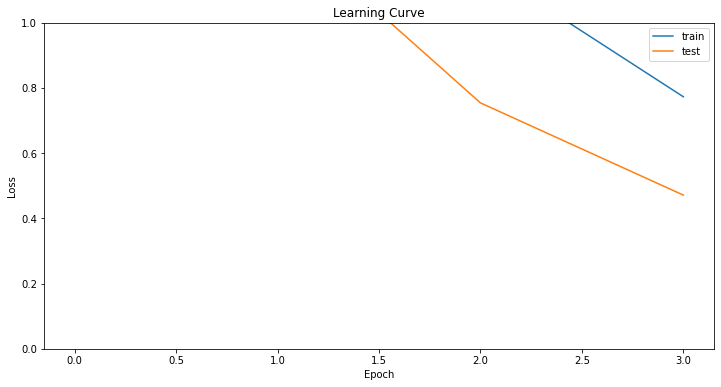

In [35]:
draw_learning_curve(history, key='loss', ylim=(0., 1.))